# Image Classifier
## 1. Setup
#### 1. Install dependencies

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [ ]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by setting GPU memory consumption growth (In case GPU is used)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimantal.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

#### 1.2 Remove unfit images

In [ ]:
import cv2
import imghdr

In [ ]:
data_directory = 'data'
data_classes = os.listdir(data_directory)

In [ ]:
os.listdir(os.path.join(data_directory, 'angry'))

In [ ]:
image_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
for image_class in data_classes:
    for image in os.listdir(os.path.join(data_directory, image_class)):
        image_path = os.path.join(data_directory, image_class, image)
        try:
            img = cv2.imread(image_path) # Checking whether the image can be loaded into opencv
            tip = imghdr.what(image_path) # Getting the image type to filter it afterwards
            if tip not in image_extensions:
                print('Image not in extensions list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

#### 1.3 Load Data

In [ ]:
# Tensorflow API
tf.data.Dataset??

In [ ]:
tf.data.Dataset.list_files

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data') # Helper used to load data

In [ ]:
data_iterator = data.as_numpy_iterator() # Converting to iterate the data more easily

In [ ]:
# Get another batch from the iterator
batch = data_iterator.next()

- Images get automatically resized to `256x256`.
- Also sets a batch size (Changeable).

In [ ]:
# Images represented as numpy arrays
batch[0].shape

In [ ]:
# Labels
# CLASS 0: Angry
# CLASS 1: Calm
batch[1]

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20)) # Used to plot out 4 images
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].title.set_text(batch[1][index])

## 2. Preprocess Data
#### 2.1 Scale Data

In [ ]:
data = data.map(lambda x, y: (x/255, y)) # Execute a function across the dataset to scale it

In [122]:
data.as_numpy_iterator().next()[0].max() # The max will be 1 and the min 0

1.0

#### 2.2 Split Data

In [ ]:
len(data) # Number of batches

In [ ]:
training_size = int(len(data)*.7)
validation_size = int(len(data)*.2)
testing_size = int(len(data)*.1)+1

In [ ]:
testing_size + training_size + validation_size

In [ ]:
# Data needs to be shuffled before this (already done in this case)
train = data.take(training_size)
validation = data.skip(training_size).take(validation_size)
testing = data.skip(training_size+validation_size).take(testing_size)

## 3. Deep Model
#### 3.1 Build the Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
# model = Sequantial([Conv2D, ...])

In [ ]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3))) # 16 filters of 3x3 size stepping every 1 pixel, relu - rectified linear unit
model.add(MaxPooling2D()) # Condenses the information (width and height) by taking the max value after the relu activation (goes over a 2x2 region and takes the max)

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # transforms the feature maps into a 1D vector. 

model.add(Dense(256, activation='relu')) # First Dense layer with 256 neurons (Dense beacause they are fully conencted)
model.add(Dense(1, activation='sigmoid')) # sigmoid converts every value to a value between 0-1 (angry or calm)

In [ ]:
model.compile('adam', loss=tf.losses.BinaryFocalCrossentropy(), metrics=['accuracy']) # adam is the optimizer, then the loss function and the metric of evaluation during training

In [ ]:
model.summary()

The convolutional layers will scale down data, this can be prevented by adding **padding**.

#### 3.2 Train

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
history = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback]) # epochs is how long training lasts, how many runs the model will go through the data

#### 3.3 Plot Performance

In [ ]:
history.history

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show

In the case where the val_loss starts to go up and the loss keeps going down could indicate that the model is overfitting (has a variance problem): in this case the best approach would be regularization, applying some data or change some data.

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show

## 4. Evaluate Performance
#### 4.1 Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [ ]:
for batch in testing.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

In [ ]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

#### 4.2 Test

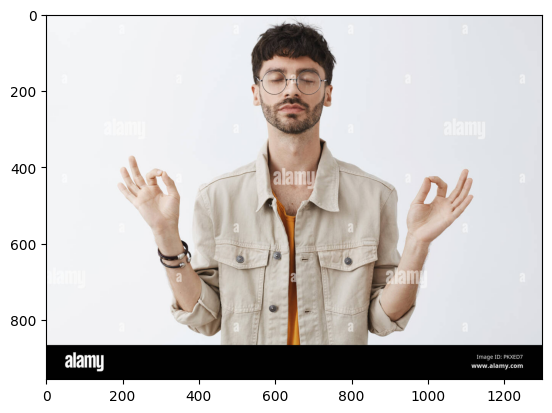

In [127]:
img = cv2.imread('calmtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # display might be weird beacuse opencv reads it in bgr
plt.show()

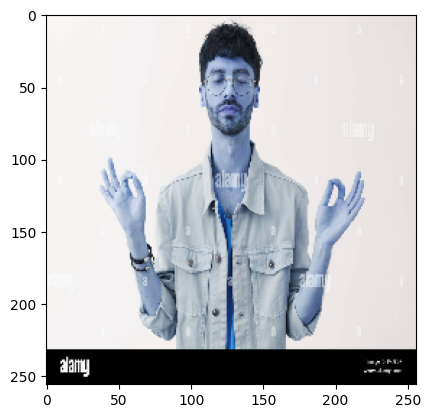

In [128]:
resized_image = tf.image.resize(img, (256, 256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [137]:
# encapsulating the image into another dimension (list) because the CNN expects a batch of images
# The 0 stnads for the axis where the extra dimension will be added
yhat = model.predict(np.expand_dims(resized_image/255, 0))

1/1 [==============================] - 0s 27ms/step


In [130]:
yhat

array([[0.98754704]], dtype=float32)

In [144]:
def happy_or_sad(yaht):
    if yhat > 0.5:
        print("Predicted class is Calm")
    else:
        print("Predicted class is Angry")

In [132]:
happy_or_sad(yhat)

Predicted class is Calm


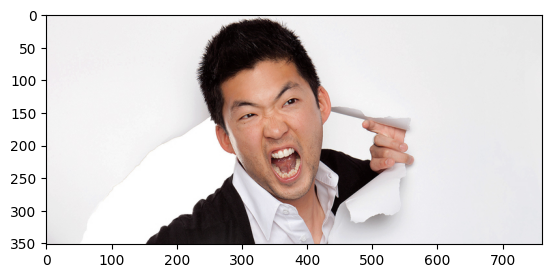

In [133]:
img = cv2.imread('angrytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

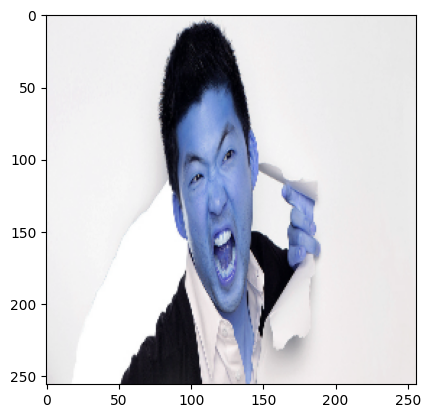

In [134]:
resized_image = tf.image.resize(img, (256, 256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [136]:
yhat = model.predict(np.expand_dims(resized_image/255, 0))
print(yhat)
happy_or_sad(yhat)

1/1 [==============================] - 0s 27ms/step
[[0.24196942]]
Predicted class id Angry


## 5. Save the Model
#### Save

In [138]:
from tensorflow.keras.models import load_model

In [139]:
model.save(os.path.join('models', 'calmangrymodel.h5')) # save the model in models folder

C:\Users\danie\Desktop\Image Classifier\imageclassifier\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [142]:
new_model = load_model(os.path.join('models', 'calmangrymodel.h5'))

In [143]:
yhat_new = new_model.predict(np.expand_dims(resized_image/255, 0))
happy_or_sad(yhat_new)

1/1 [==============================] - 0s 82ms/step
Predicted class id Angry
